<a href="https://colab.research.google.com/github/sssylvia0/Uplift_Model/blob/main/Model_Nov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Uplift and Profit prediction

1. Model (Traning Data: data202306.csv)

*  **Uplift**:  CasualML_uplift_202306_1-5.pkl

* **X-Learner**:  'EconML_X_202306_new_1.pkl', 'Value_EconML_X_202306.pkl',

*   **Profit**:  Econml_RF_202306.pkl, Econml_CF_202306.pkl

2. Time：約20分鐘
   
   需要手動重啟!





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202401.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [1]:
import pandas as pd
import numpy as np

# Load your May data
jan_data = pd.read_csv('/content/data202401.csv', index_col=0)

unino = jan_data['UNINO']
X_names = jan_data.columns.drop(['換匯發送名單','TOTALNTAMOUNT', '跨售行為', 'UNINO', '客戶行業別_軍火商'])
jan_data['客戶行業別_其他'] = np.where((jan_data['客戶行業別_其他'] == 0) & (jan_data['客戶行業別_軍火商'] == 1), 1, jan_data['客戶行業別_其他'])
jan_data.drop(['換匯發送名單','TOTALNTAMOUNT', '跨售行為', 'UNINO', '客戶行業別_軍火商'], axis = 'columns', inplace = True)

#201 columns
X_names

Index(['年齡', '公司戶記號', '性別', '呆帳記號_含信用卡', '客戶年收入', '網路會員記號', '網路使用記號_行動銀行',
       '小mma記號', '網路服務記號', '網路使用記號',
       ...
       '客戶行業別_醫療保健', '客戶行業別_金融業', '客戶行業別_電子業', '對帳單寄送記號_0', '對帳單寄送記號_1',
       '對帳單寄送記號_2', '信用卡VIP客戶註記_Y', '外幣存款記號_Y', '信用卡轉呆記號_Y', '信用卡自動扣款記號_Y'],
      dtype='object', length=201)

## CausalML

In [16]:
!pip install causalml
!pip install duecredit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 25.2 MB/s eta 0:00:00
  Using cached Cython-0.29.34-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
  Created wh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.6/86.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 kB 10.2 MB/s eta 0:00:00


In [3]:
import importlib
print(importlib.metadata.version('scikit-learn') )

1.2.2


In [2]:
import numpy as np
import pandas as pd
import duecredit

from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain, get_cumgain
from sklearn.model_selection import train_test_split

import importlib
print(importlib.metadata.version('causalml') )

0.15.0


In [6]:
%%time
import pickle
def load_model(model_path):
   """Load a pickled model."""
   return pickle.load(open(model_path, "rb"))

def get_results(model_index, df, data, model_prefix="CasualML_uplift_202312_"):
   """Run model predictions and update DataFrame."""
   model_path = f"/content/drive/MyDrive/Model/{model_prefix}{model_index}.pkl"
   model = load_model(model_path)
   #df_res = model.predict(data, full_output=True)
   df_res = model.predict(data[X_names], full_output=True)
   df[f'Uplift_{model_index}|T=0'] = df_res.iloc[:, 0]
   df[f'Uplift_{model_index}|T=1'] = df_res.iloc[:, 1]
   print(f'Finish running uplift_new_{model_index}')
   return df

def calculate_mean_uplifts(res, model_count=5):
   """Calculate mean uplifts and return a DataFrame."""
   T = [f'Uplift_{i}|T=0' for i in range(1, model_count + 1)]
   T1 = [f'Uplift_{i}|T=1' for i in range(1, model_count + 1)]
   res_columns = res[T + T1]
   #pred = pd.DataFrame()
   pred['Uplift_mean|T=0'] = res_columns[T].mean(axis=1)
   pred['Uplift_mean|T=1'] = res_columns[T1].mean(axis=1)
   pred['Uplift_mean'] = pred['Uplift_mean|T=1'] - pred['Uplift_mean|T=0']
   return pred

# Example usage
res_df = pd.DataFrame()
for i in range(1, 6):
   res_df = get_results(i, res_df, jan_data)
pred = pd.DataFrame()
pred = calculate_mean_uplifts(res_df)
pred

CPU times: user 349 ms, sys: 3.7 ms, total: 352 ms
Wall time: 919 ms


,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean
0,0.002211,0.019590,0.017379
1,0.001196,0.024855,0.023659
2,0.001224,0.024305,0.023081
3,0.001047,0.023858,0.022810
4,0.002841,0.024011,0.021170
...,...,...,...
1092946,0.002239,0.007922,0.005683
1092947,0.001201,0.013335,0.012134
1092948,0.001961,0.011365,0.009403
1092949,0.001175,0.024510,0.023335


In [7]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092951 entries, 0 to 1092950
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Uplift_mean|T=0  1092951 non-null  float64
 1   Uplift_mean|T=1  1092951 non-null  float64
 2   Uplift_mean      1092951 non-null  float64
dtypes: float64(3)
memory usage: 25.0 MB


In [8]:
#暫存causalml的結果
#pred.to_csv('temp.csv')
pred.to_pickle('temp.pkl')

##X-Learner

In [9]:
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 39.5 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.44.1
    Uninstalling shap-0.44.1:
      Successfully uninstalled shap-0.44.1


In [3]:
!pip install scikit-learn==1.2.2
!pip install --upgrade DecisionTreeClassifier

In [ ]:
#避免版本衝突，重新下載之後需要手動重啟

In [1]:
import importlib
print(importlib.metadata.version('scikit-learn') )

1.2.2


In [2]:
import pandas as pd
import numpy as np

# Load your May data
jan_data = pd.read_csv('/content/data202401.csv', index_col=0)

unino = jan_data['UNINO']
jan_data['客戶行業別_其他'] = np.where((jan_data['客戶行業別_其他'] == 0) & (jan_data['客戶行業別_軍火商'] == 1), 1, jan_data['客戶行業別_其他'])
jan_data.drop(['換匯發送名單','TOTALNTAMOUNT', '跨售行為', 'UNINO', '客戶行業別_軍火商'], axis = 'columns', inplace = True)

In [4]:
# Main imports
from econml.metalearners import XLearner

# Helper imports
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
%%time
import pickle
import pandas as pd

def get_other_results(model_list, name_list, df, data):
  for i in range(len(model_list)):
    with open ("/content/drive/MyDrive/Model/"+ model_list[i], "rb") as file:
      est = pickle.load(file)
    if i ==2:
      df[name_list[i]] = est.predict(data)
    else :
      df[name_list[i]] = est.effect(data)
  return df

##使用
#pred = pd.read_csv('temp.csv', index_col = 0)
pred = pd.read_pickle('temp.pkl')
pred = pred.apply(pd.to_numeric, errors='coerce', downcast='float')
pred.insert(0, '換匯基因標籤', jan_data['換匯基因標籤'].values)
pred.insert(0, 'UNINO', unino.values)
model_list = ['EconML_X_202309.pkl', 'Value_EconML_X_202312.pkl', 'Econml_RF_202309.pkl', 'Econml_CF_202309.pkl']
name_list = ['X_te', 'Value_X', 'E(V)|T = 0, D = 1', 'te']
pred = get_other_results(model_list, name_list, pred, jan_data)
pred['E(V)|T = 1, D = 1'] = pred['E(V)|T = 0, D = 1'] + pred['te']
pred
#pred.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202311.csv')
#1066146 rows × 10 columns
#pred.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202312.csv')
#1072120 rows × 10 columns
pred.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202401.csv')
#1092951 rows × 10 columns

CPU times: user 4min 14s, sys: 20.7 s, total: 4min 35s
Wall time: 4min 14s


In [6]:
#pred = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202312.csv', index_col = 0)
#pred.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202312.csv')
pred
#1072120 rows × 10 columns

,UNINO,換匯基因標籤,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
0,19012621YA8,97.4905,0.002211,0.019590,0.017379,0.000652,5.625413,870.291512,9885.445385,10755.736897
1,19039293TA8,75.0871,0.001196,0.024855,0.023659,0.000227,5.426625,867.810111,4047.782936,4915.593047
2,19042120PA8,73.8688,0.001224,0.024305,0.023081,0.000227,5.436940,853.967076,3815.248853,4669.215929
3,19052324OK8,46.5027,0.001047,0.023858,0.022810,0.000301,5.382714,852.026721,3866.789112,4718.815832
4,19052578MU0,96.0861,0.002841,0.024011,0.021170,-0.023189,-97.184597,855.063200,-377.586411,477.476789
...,...,...,...,...,...,...,...,...,...,...
1092946,Z2229999030,91.0430,0.002239,0.007922,0.005683,0.000219,5.667979,867.740493,-250.277907,617.462586
1092947,Z2422221010,79.1173,0.001201,0.013335,0.012134,0.000228,5.404878,846.572525,-4765.915744,-3919.343219
1092948,Z2422273090,88.4721,0.001961,0.011365,0.009403,-0.000467,5.485621,860.915018,-378.483668,482.431350
1092949,Z2794749990,77.1648,0.001175,0.024510,0.023335,-0.000476,5.426911,846.502166,2228.319640,3074.821807


In [7]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092951 entries, 0 to 1092950
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   UNINO              1092951 non-null  object 
 1   換匯基因標籤             1092951 non-null  float64
 2   Uplift_mean|T=0    1092951 non-null  float32
 3   Uplift_mean|T=1    1092951 non-null  float32
 4   Uplift_mean        1092951 non-null  float32
 5   X_te               1092951 non-null  float64
 6   Value_X            1092951 non-null  float64
 7   E(V)|T = 0, D = 1  1092951 non-null  float64
 8   te                 1092951 non-null  float64
 9   E(V)|T = 1, D = 1  1092951 non-null  float64
dtypes: float32(3), float64(6), object(1)
memory usage: 70.9+ MB


In [8]:
pred.describe()

,換匯基因標籤,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
count,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06
mean,7.319686e+01,1.544139e-03,1.708374e-02,1.553960e-02,1.348406e-03,7.697545e+01,2.359947e+03,-4.751201e+02,1.884827e+03
std,1.524822e+01,1.176748e-03,6.549410e-03,7.163807e-03,2.885127e-02,5.536370e+03,1.800565e+04,3.510448e+03,2.003595e+04
min,1.092000e-01,4.690073e-04,2.389791e-03,-2.105443e-02,-7.543967e-01,-9.113465e+05,8.281751e+02,-1.638002e+04,-9.415603e+03
25%,5.927135e+01,9.793860e-04,1.260857e-02,1.116009e-02,-9.100040e-06,5.384098e+00,8.497196e+02,-2.463378e+03,-1.360956e+03
50%,7.480430e+01,1.255224e-03,1.480617e-02,1.350123e-02,1.540745e-04,5.463598e+00,8.523757e+02,-9.230825e+01,8.122942e+02
75%,8.581235e+01,1.651195e-03,2.335218e-02,2.211693e-02,3.002659e-04,5.681967e+00,8.635658e+02,7.669986e+02,1.692197e+03
max,9.999900e+01,2.795761e-02,4.147653e-02,4.096877e-02,1.583903e+00,2.034894e+06,7.398225e+05,1.216707e+05,8.074874e+05


In [9]:
res = pd.DataFrame()
res = pred.iloc[:,:7]
#res['X_te'] = pred['X_te']
res['E(V)|X,T = 0'] = pred['Uplift_mean|T=0'] * pred['E(V)|T = 0, D = 1']
res['E(V)|X,T = 1'] = pred['Uplift_mean|T=1'] * pred['E(V)|T = 1, D = 1']
res['Gi'] = res['E(V)|X,T = 1']-res['E(V)|X,T = 0']
#res['Value_mean'] = pred['Value_mean']
res
#res.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_All_202312.csv')
#1066146 rows × 10 columns
#res.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_All_202401.csv')
#1092951 rows × 10 columns

,UNINO,換匯基因標籤,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|X,T = 0","E(V)|X,T = 1",Gi
0,19012621YA8,97.4905,0.002211,0.019590,0.017379,0.000652,5.625413,1.924174,210.706225,208.782051
1,19039293TA8,75.0871,0.001196,0.024855,0.023659,0.000227,5.426625,1.037959,122.179432,121.141473
2,19042120PA8,73.8688,0.001224,0.024305,0.023081,0.000227,5.436940,1.045334,113.487480,112.442146
3,19052324OK8,46.5027,0.001047,0.023858,0.022810,0.000301,5.382714,0.892248,112.579326,111.687078
4,19052578MU0,96.0861,0.002841,0.024011,0.021170,-0.023189,-97.184597,2.429427,11.464856,9.035428
...,...,...,...,...,...,...,...,...,...,...
1092946,Z2229999030,91.0430,0.002239,0.007922,0.005683,0.000219,5.667979,1.942806,4.891624,2.948818
1092947,Z2422221010,79.1173,0.001201,0.013335,0.012134,0.000228,5.404878,1.016975,-52.265328,-53.282303
1092948,Z2422273090,88.4721,0.001961,0.011365,0.009403,-0.000467,5.485621,1.688575,5.482702,3.794127
1092949,Z2794749990,77.1648,0.001175,0.024510,0.023335,-0.000476,5.426911,0.995037,75.365102,74.370065


In [10]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_All_202401.csv')

In [11]:
res.describe()

,換匯基因標籤,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|X,T = 0","E(V)|X,T = 1",Gi
count,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06,1.092951e+06
mean,7.319686e+01,1.544139e-03,1.708374e-02,1.553960e-02,1.348406e-03,7.697545e+01,1.158843e+01,2.960748e+01,1.801905e+01
std,1.524822e+01,1.176748e-03,6.549410e-03,7.163807e-03,2.885127e-02,5.536370e+03,1.704266e+02,2.501217e+02,1.704218e+02
min,1.092000e-01,4.690073e-04,2.389791e-03,-2.105443e-02,-7.543967e-01,-9.113465e+05,3.973673e-01,-1.427619e+02,-9.835006e+03
25%,5.927135e+01,9.793860e-04,1.260857e-02,1.116009e-02,-9.100040e-06,5.384098e+00,8.336243e-01,-1.466735e+01,-1.778725e+01
50%,7.480430e+01,1.255224e-03,1.480617e-02,1.350123e-02,1.540745e-04,5.463598e+00,1.070439e+00,1.177290e+01,1.022025e+01
75%,8.581235e+01,1.651195e-03,2.335218e-02,2.211693e-02,3.002659e-04,5.681967e+00,1.435527e+00,3.367279e+01,3.199794e+01
max,9.999900e+01,2.795761e-02,4.147653e-02,4.096877e-02,1.583903e+00,2.034894e+06,1.282829e+04,1.688748e+04,1.512200e+04


In [ ]:
res[['Gi', 'Value_X']].describe()

,Gi,Value_X
count,886737.000000,1.072120e+06
mean,607.871700,1.397476e+02
std,3097.570612,9.912666e+03
min,-96075.826393,-9.596452e+05
25%,-693.810072,1.445234e+01
50%,179.510563,1.453936e+01
75%,2751.681293,1.477431e+01
max,29764.271057,1.772891e+06


In [12]:
res['Gi'].corr(res['Value_X'])

0.12672312678968106

##Plot

In [ ]:
import pandas as pd
pred = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202311.csv', index_col = 0)
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_All_202311.csv', index_col = 0)
res

,UNINO,換匯基因標籤,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te_2,Value_X,"E(V)|X,T = 0","E(V)|X,T = 1",Gi
0,19039293TA8,77.3359,0.002628,0.052883,0.050255,0.007603,224.755418,303.405873,5219.427322,4916.021449
1,19042120PA8,74.6927,0.002283,0.054769,0.052486,-0.000304,224.542288,245.168882,4876.076911,4630.908028
2,19052324OK8,49.4634,0.002006,0.053777,0.051771,0.008625,223.611054,258.540957,5922.655810,5664.114853
3,19052578MU0,95.2704,0.005964,0.042626,0.036662,0.010950,792.579159,1119.718721,7147.166280,6027.447559
4,19079774PA8,62.5524,0.002192,0.053800,0.051608,0.004067,227.106518,221.916105,4498.231832,4276.315727
...,...,...,...,...,...,...,...,...,...,...
1066141,Z2229999030,91.0734,0.005433,0.029495,0.024062,0.000424,802.572909,829.064396,4020.703672,3191.639275
1066142,Z2422221010,63.8297,0.002295,0.041293,0.038998,0.008121,282.955875,306.799286,5021.857003,4715.057718
1066143,Z2422273090,92.3213,0.004226,0.035025,0.030799,0.006075,322.413851,702.400425,5222.260430,4519.860005
1066144,Z2794749990,76.5699,0.002432,0.051877,0.049445,0.009300,225.050452,236.065929,4111.878184,3875.812256


In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(res.iloc[:,1], res['X_te_2'])
plt.xlabel('Gene PR')
plt.ylabel('X-Learner(pred)')
plt.subplot(122)
plt.scatter(res.iloc[:,1], res.iloc[:,-1])
plt.xlabel('Gene PR')
plt.ylabel('Gi(pred)')
plt.legend()

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize =(15, 10))

plt.subplot(141)
plt.boxplot(res['Uplift_mean'], labels=['Uplift_mean'])
# Creating plot
plt.subplot(142)
plt.boxplot(res['X_te_2'], labels=['X-Learner'])
plt.subplot(143)
plt.boxplot(res[['Uplift_mean|T=0', 'Uplift_mean|T=1']], labels=['Uplift|T=0', 'Uplift|T=1'])
plt.subplot(144)
plt.boxplot(res[['E(V)|X,T = 0', 'E(V)|X,T = 1']], labels=['E(V)|T=0', 'E(V)|T=1'])

# show plot
plt.show()

# 名單

In [ ]:
import numpy as np

In [ ]:
#Lift
print('90% X_te: ',np.percentile(res['X_te_2'], 90, axis = 0))
T = res['UNINO'][res['X_te_2']>=np.percentile(res['X_te_2'], 90, axis = 0)]
print('Length of 90% X_te: ',len(T)) #106615
#90% X_te:  0.018709309989785698

90% X_te:  0.018709309989785698
Length of 90% X_te:  106615


In [ ]:
#Value
print('90% Value_X: ',np.percentile(res['Value_X'], 90, axis = 0))
Value_X = res['UNINO'][res['Value_X']>=np.percentile(res['Value_X'], 90, axis = 0)]
print('Length of 90% Value_X: ',len(Value_X)) #106675
#90% Value_X:  491.99262074479896

90% Value_X:  491.99262074479896
Length of 90% Value_X:  106675


In [ ]:
df = res.copy()

##Total value
#Decide the length of the list
tenpercent = round(len(df)/10) #106615
#print the number of the sum that should be bigger
l = df.sort_values(by='E(V)|X,T = 1', ascending=False)[:tenpercent+1].UNINO
selected_df = df[df.UNINO.isin(l)]
#Check whether there's bigger sum
if (selected_df['E(V)|X,T = 1']<selected_df['E(V)|X,T = 0']).sum():
    one = selected_df[selected_df['E(V)|X,T = 1']<selected_df['E(V)|X,T = 0']]
    print('Needs to be changed:', len(one))
    selected_df_0 = df[~df.UNINO.isin(l)]
    change = selected_df_0[selected_df_0['E(V)|X,T = 1']-selected_df_0['E(V)|X,T = 0']>0].sort_values(by = 'Gi')['UNINO'][:len(one)]
    new_l = set(l)-set(one)|(set(change))
else:
    new_l = selected_df.UNINO
#Result
print(len(new_l))

106616


In [ ]:
#Check the maximum sum
print('Total value namelist sum:', df[df.UNINO.isin(new_l)]['E(V)|X,T = 1'].sum() + df[~df.UNINO.isin(new_l)]['E(V)|X,T = 0'].sum()) #970234611.7105305
print('Lift namelist sum:', df[df.UNINO.isin(T)]['E(V)|X,T = 1'].sum() + df[~df.UNINO.isin(T)]['E(V)|X,T = 0'].sum()) #706845425.3346279
print('Value namelist sum:', df[df.UNINO.isin(Value_X)]['E(V)|X,T = 1'].sum() + df[~df.UNINO.isin(Value_X)]['E(V)|X,T = 0'].sum()) #808195019.5952859

Total value namelist sum: 970234611.7105305
Lift namelist sum: 706845425.3346279
Value namelist sum: 808195019.5952859


In [ ]:
setA1 = set(new_l)
setC1 = set(T)
setB1 = set(Value_X)


setTLV = setA1 & setC1 & setB1
setTL = setA1 & setC1-setTLV
setLV = setC1 & setB1-setTLV
setTV = setA1 & setB1-setTLV
setT = setA1-setTL-setTV-setTLV
setL = setC1-setTL-setLV-setTLV
setV = setB1-setTV-setLV-setTLV

print("Length of S: ", len(setT)) #50653 #58074 #11209
print("Length of L: ", len(setL)) #84167 #41878 #45596
print("Length of V: ", len(setV)) #95575 #46559 #46919
print("Length of SL: ", len(setTL)) #13490 #6416 #2525
print("Length of LV: ", len(setLV)) #7787 #4428 #4601
print("Length of SV: ", len(setTV)) #2082 #1735 #1202
print("Length of common namelist(SLV): ", len(setTLV)) #514 #314
'''
Length of S:  75568
Length of L:  82480
Length of V:  65712
Length of SL:  4904
Length of LV:  14819
Length of SV:  21732
Length of common namelist(SLV):  4412
'''

Length of S:  75568
Length of L:  82480
Length of V:  65712
Length of SL:  4904
Length of LV:  14819
Length of SV:  21732
Length of common namelist(SLV):  4412


'\nLength of S:  75568\nLength of L:  82480\nLength of V:  65712\nLength of SL:  4904\nLength of LV:  14819\nLength of SV:  21732\nLength of common namelist(SLV):  4412\n'

In [ ]:
res.columns

Index(['UNINO', '換匯基因標籤', 'Uplift_mean|T=0', 'Uplift_mean|T=1', 'Uplift_mean',
       'X_te_2', 'Value_X', 'E(V)|X,T = 0', 'E(V)|X,T = 1', 'Gi'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def Split_equally(SetName):
  # 初始化两个DataFrame，用于存储分割后的子集
  df1 = pd.DataFrame()
  df2 = pd.DataFrame()

  # 根据每个百分位数切割数据，并将子集存入DataFrame
  for percentile in range(100, 0, -1):
    cutoff = np.percentile(res['E(V)|X,T = 0'][res['UNINO'].isin(SetName)], percentile)
    cutoff_1 = np.percentile(res['E(V)|X,T = 0'][res['UNINO'].isin(SetName)], percentile-1)
    data = res[(res['E(V)|X,T = 0'] <= cutoff) & (res['E(V)|X,T = 0'] > cutoff_1) & (res['UNINO'].isin(SetName))]
    if len(data)==0:
      print(percentile, "PASS")
      continue
    subset1, subset2 = train_test_split(data, test_size=0.5, random_state=999)

    df1 = pd.concat([df1, subset1])
    df2 = pd.concat([df2, subset2])

  #percentile = 0
  cutoff = np.percentile(res['E(V)|X,T = 0'][res['UNINO'].isin(SetName)], 0)
  df1 = pd.concat([df1, res[(res['E(V)|X,T = 0'] <= cutoff) & (res['UNINO'].isin(SetName))]])


  print(len(df1)+len(df2), len(SetName)) #該如何讓這兩個df完全包括subset
  return df1, df2

In [ ]:
sets = {}
# Lists for keys and values
keys_list = ['setT', 'setL', 'setV', 'setTL', 'setLV', 'setTV', 'setTLV' ]
values_list = [setT, setL, setV, setTL, setLV, setTV, setTLV]

# Using the zip() function and the dict() constructor
sets = dict(zip(keys_list, values_list))
sets.keys()

dict_keys(['setT', 'setL', 'setV', 'setTL', 'setLV', 'setTV', 'setTLV'])

In [ ]:
%%time
result_dict = {}  # 创建一个字典来存储结果

for key in sets.keys():
  result_dict[f'{str(key)}_1'], result_dict[f'{str(key)}_2'] = Split_equally(sets[key])
  print(str(key), ': ')
  print(f'{str(key)}第一個子集長度：', len(result_dict[f'{str(key)}_1']), ', BASE平均：', round(result_dict[f'{str(key)}_1']['Uplift_mean|T=0'].mean(), 6),', 金額平均：', round(result_dict[f'{str(key)}_1']['E(V)|X,T = 0'].mean(), 6))
  print(f'{str(key)}第二個子集長度：', len(result_dict[f'{str(key)}_2']), ', BASE平均：', round(result_dict[f'{str(key)}_2']['Uplift_mean|T=0'].mean(), 6),', 金額平均：', round(result_dict[f'{str(key)}_2']['E(V)|X,T = 0'].mean(), 6))

75568 75568
setT : 
setT第一個子集長度： 37767 , BASE平均： 0.002416 , 金額平均： 383.448758
setT第二個子集長度： 37801 , BASE平均： 0.002414 , 金額平均： 382.856712
82480 82480
setL : 
setL第一個子集長度： 41203 , BASE平均： 0.003475 , 金額平均： 331.829381
setL第二個子集長度： 41277 , BASE平均： 0.003467 , 金額平均： 331.638899
65712 65712
setV : 
setV第一個子集長度： 32812 , BASE平均： 0.004623 , 金額平均： 682.562583
setV第二個子集長度： 32900 , BASE平均： 0.004629 , 金額平均： 683.706816
4904 4904
setTL : 
setTL第一個子集長度： 2404 , BASE平均： 0.005134 , 金額平均： 1126.825587
setTL第二個子集長度： 2500 , BASE平均： 0.005127 , 金額平均： 1129.128322
14819 14819
setLV : 
setLV第一個子集長度： 7401 , BASE平均： 0.005335 , 金額平均： 700.318684
setLV第二個子集長度： 7418 , BASE平均： 0.005319 , 金額平均： 700.109018
21732 21732
setTV : 
setTV第一個子集長度： 10832 , BASE平均： 0.004427 , 金額平均： 825.742269
setTV第二個子集長度： 10900 , BASE平均： 0.004418 , 金額平均： 825.728255
4412 4412
setTLV : 
setTLV第一個子集長度： 2201 , BASE平均： 0.006076 , 金額平均： 1354.207774
setTLV第二個子集長度： 2211 , BASE平均： 0.006081 , 金額平均： 1355.699762
CPU times: user 6min, sys: 1.2 s, total: 6min 1s
Wall

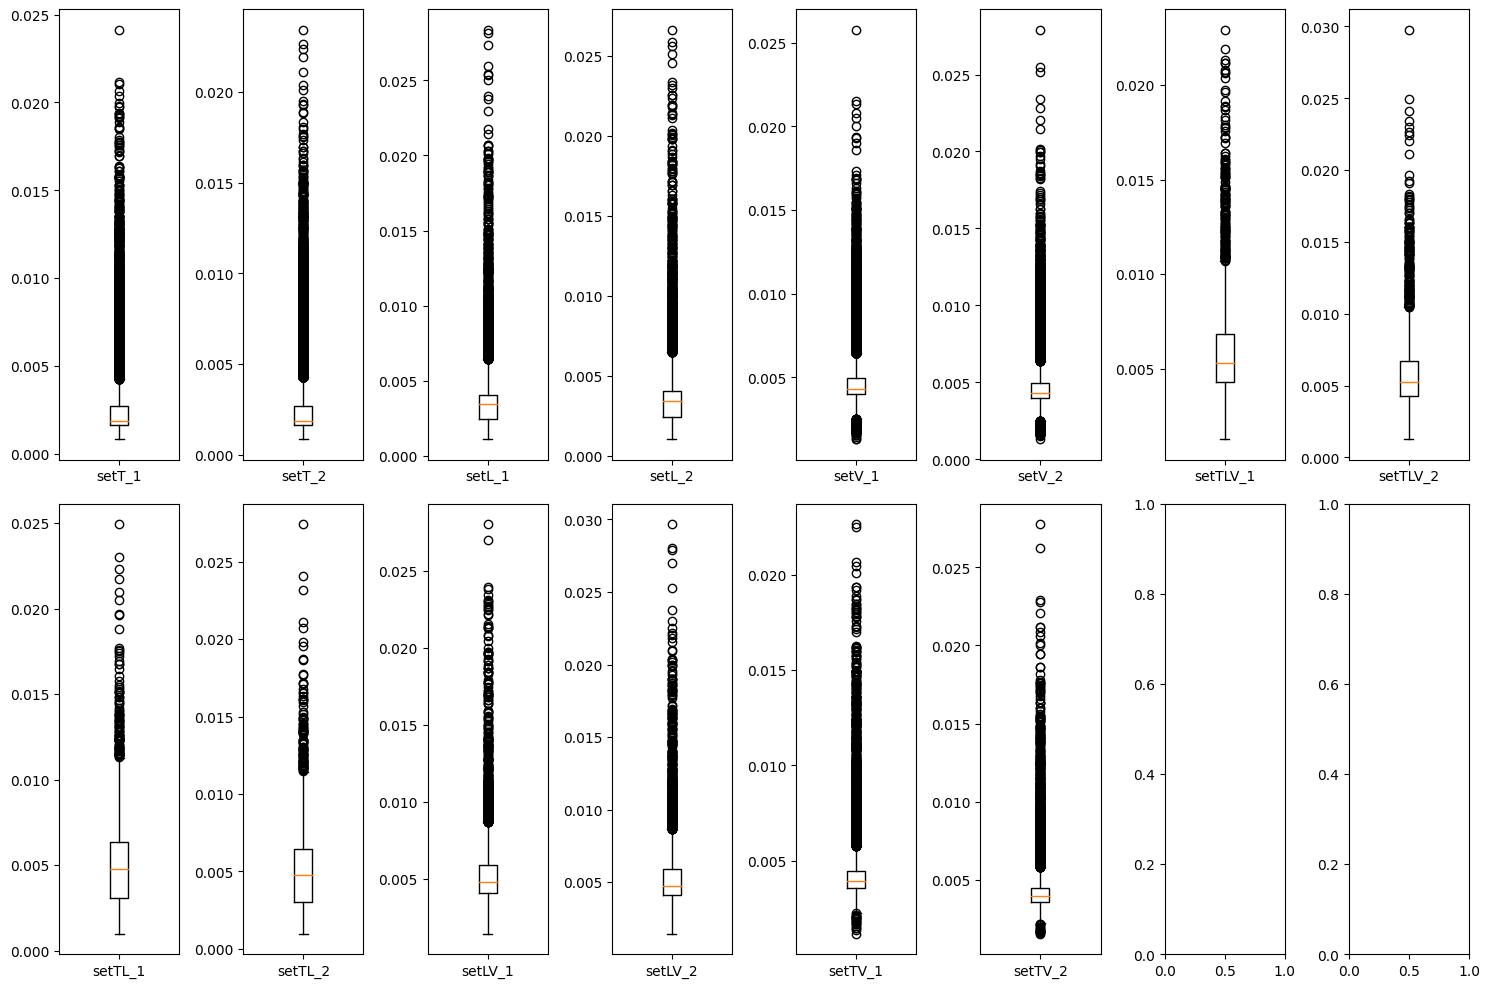

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,8,figsize = (15, 10))
#S
ax[0,0].boxplot(result_dict['setT_1']['Uplift_mean|T=0'], labels=['setT_1'])
ax[0,1].boxplot(result_dict['setT_2']['Uplift_mean|T=0'], labels=['setT_2'])
#L
ax[0,2].boxplot(result_dict['setL_1']['Uplift_mean|T=0'], labels=['setL_1'])
ax[0,3].boxplot(result_dict['setL_2']['Uplift_mean|T=0'], labels=['setL_2'])
#V
ax[0,4].boxplot(result_dict['setV_1']['Uplift_mean|T=0'], labels=['setV_1'])
ax[0,5].boxplot(result_dict['setV_2']['Uplift_mean|T=0'], labels=['setV_2'])

#SL
ax[1,0].boxplot(result_dict['setTL_1']['Uplift_mean|T=0'], labels=['setTL_1'])
ax[1,1].boxplot(result_dict['setTL_2']['Uplift_mean|T=0'], labels=['setTL_2'])
#LV
ax[1,2].boxplot(result_dict['setLV_1']['Uplift_mean|T=0'], labels=['setLV_1'])
ax[1,3].boxplot(result_dict['setLV_2']['Uplift_mean|T=0'], labels=['setLV_2'])
#SV
ax[1,4].boxplot(result_dict['setTV_1']['Uplift_mean|T=0'], labels=['setTV_1'])
ax[1,5].boxplot(result_dict['setTV_2']['Uplift_mean|T=0'], labels=['setTV_2'])

#SLV
ax[0,6].boxplot(result_dict['setTLV_1']['Uplift_mean|T=0'], labels=['setTLV_1'])
ax[0,7].boxplot(result_dict['setTLV_2']['Uplift_mean|T=0'], labels=['setTLV_2'])
plt.tight_layout()
plt.show()

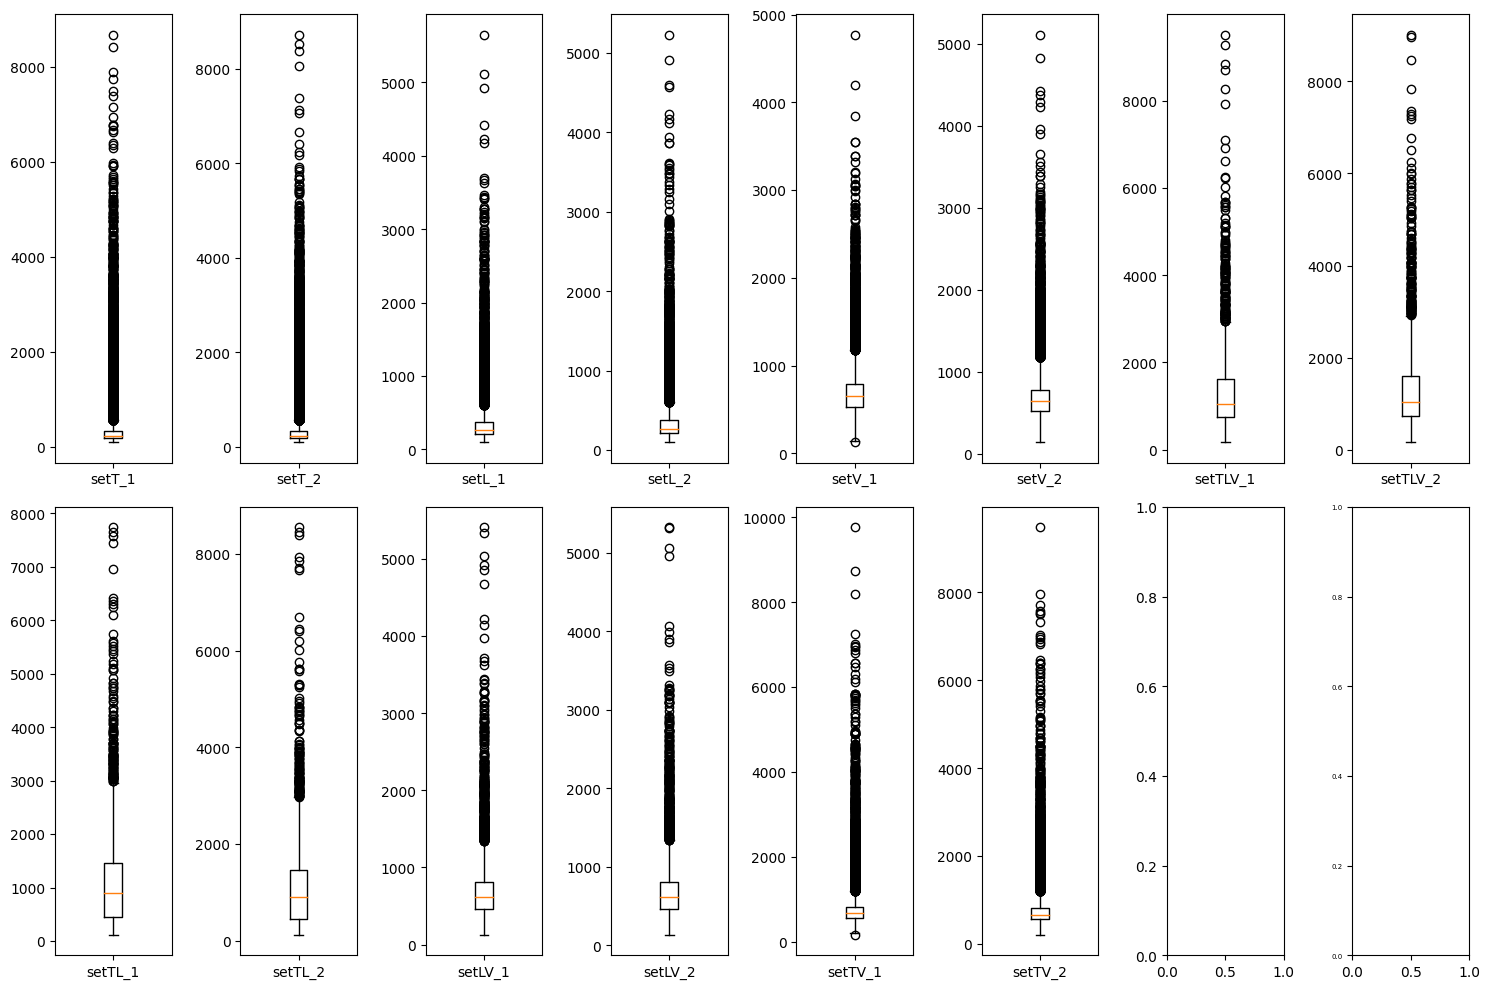

In [ ]:
fig, ax = plt.subplots(2,8,figsize = (15, 10))
#S
ax[0,0].boxplot(result_dict['setT_1']['E(V)|X,T = 0'], labels=['setT_1'])
ax[0,1].boxplot(result_dict['setT_2']['E(V)|X,T = 0'], labels=['setT_2'])
#L
ax[0,2].boxplot(result_dict['setL_1']['E(V)|X,T = 0'], labels=['setL_1'])
ax[0,3].boxplot(result_dict['setL_2']['E(V)|X,T = 0'], labels=['setL_2'])
#V
ax[0,4].boxplot(result_dict['setV_1']['E(V)|X,T = 0'], labels=['setV_1'])
ax[0,5].boxplot(result_dict['setV_2']['E(V)|X,T = 0'], labels=['setV_2'])

#SL
ax[1,0].boxplot(result_dict['setTL_1']['E(V)|X,T = 0'], labels=['setTL_1'])
ax[1,1].boxplot(result_dict['setTL_2']['E(V)|X,T = 0'], labels=['setTL_2'])
#LV
ax[1,2].boxplot(result_dict['setLV_1']['E(V)|X,T = 0'], labels=['setLV_1'])
ax[1,3].boxplot(result_dict['setLV_2']['E(V)|X,T = 0'], labels=['setLV_2'])
#SV
ax[1,4].boxplot(result_dict['setTV_1']['E(V)|X,T = 0'], labels=['setTV_1'])
ax[1,5].boxplot(result_dict['setTV_2']['E(V)|X,T = 0'], labels=['setTV_2'])

#SLV
ax[0,6].boxplot(result_dict['setTLV_1']['E(V)|X,T = 0'], labels=['setTLV_1'])
ax[0,7].boxplot(result_dict['setTLV_2']['E(V)|X,T = 0'], labels=['setTLV_2'])
plt.tight_layout()
plt.yticks(fontsize=5)
plt.show()